02/06/2021

**Tiago Pereira Dall'Oca - 206341**

---

In [1]:
from scipy import misc
from scipy import ndimage
from scipy.fft import ifftn
from scipy.spatial.distance import pdist
from scipy.ndimage import rotate
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from math import sqrt 

import warnings
warnings.filterwarnings('ignore')

# Introdução

Este trabalho foi desenvolvido utilizando a plataforma de prototipação e experimentção [Jupyter](https://jupyter.org). A intenção foi permitir que o trabalho fosse desenvolvido de forma gradual, já que as celulas são executadas uma por vez e os resultdados são obtidos de forma incremental.

Estou enviando, junto do pdf do notebook,o notebook original. A intenção é que a imagem de input pode ser alterada com bastante facilidade e basta rodar as células em sequência para obter os resultados discutidos.

## Imagem escolhida

O valor de `img_file_name` pode ser modificado para o caminho de outras imagens válidas no notebook.

In [2]:
img_file_name = 'images/objetos3.png'

In [3]:
img = cv2.imread(img_file_name, cv2.IMREAD_GRAYSCALE)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

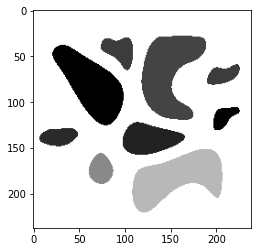

In [4]:
plt.imshow(img, 'gray')

# Transformação de cores

A imagem já foi lida em em grayscale, então temos somente que ajustar a faixa de preto e criar uma imagem equivalente porém somente com preto e branco

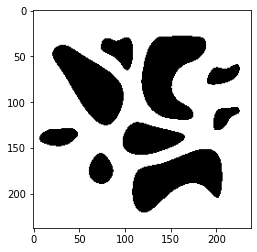

In [5]:
(t, img_bw) = cv2.threshold(img,210,255, cv2.THRESH_BINARY)
plt.imshow(img_bw, 'gray')

# Bordas

A detecção das bordas é feita usando o método pronto da Laplaciana, implementado pelo _OpenCV_

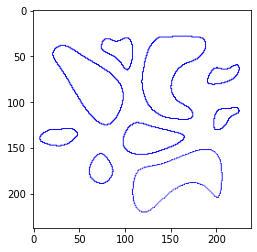

In [6]:
edges = cv2.Laplacian(img, cv2.CV_16S, ksize=3).astype(int)
background = np.where(edges,255,255)
background_minus_edges = background - edges
edges_img = cv2.merge((background_minus_edges, background_minus_edges, background))
edges_img[edges_img < 0] = 0
edges_img[edges_img > 255] = 255
plt.imshow(edges_img, 'gray')

# Propriedades


In [7]:
cs = cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
cs = np.delete(cs, 0)
len(cs) # números de regiões

9

In [8]:
areas = np.zeros((len(cs))) # vamos salvar as áreas para usar no histograma

Calculo da excentricidade:
$$
excentricidade = \frac{\sqrt{\left(\frac{eixo \space menor}{2}\right)^2 + \left(\frac{eixo \space maior}{2}\right)^2}}{\frac{eixo \space menor}{2}}
$$

In [9]:
def calc_ecc(c):
    (eM, em) = cv2.fitEllipse(c)[1]
    (aux1, aux2) = (em / 2 , eM / 2)
    ecc = sqrt(aux1*aux1 - aux2*aux2) / aux1
    return ecc

Fazendo o print das propriedades:

In [10]:
for i, c in enumerate(cs):
    mms = cv2.moments(c)
    cx, cy = (int(round(mms['m10']/mms['m00'])), int(round(mms['m01']/mms['m00'])))
    area = cv2.contourArea(c)
    areas[i] = area
    p = cv2.arcLength(c,True)
    ecc = calc_ecc(c)
    s = area/cv2.contourArea(cv2.convexHull(c))
    print('região {:>2g}:  área: {:<10.2f}  perímetro: {:<10.2f}  excentricidade: {:<4.2f}  solidez: {:<4.2f}'.format(i+1, area, p, ecc, s))

região  1:  área: 716.50      perímetro: 101.98      excentricidade: 0.63  solidez: 0.98
região  2:  área: 4067.00     perímetro: 311.08      excentricidade: 0.88  solidez: 0.78
região  3:  área: 688.50      perímetro: 108.67      excentricidade: 0.88  solidez: 0.97
região  4:  área: 1761.50     perímetro: 179.78      excentricidade: 0.88  solidez: 0.97
região  5:  área: 478.00      perímetro: 94.43       excentricidade: 0.88  solidez: 0.93
região  6:  área: 584.00      perímetro: 104.91      excentricidade: 0.87  solidez: 0.91
região  7:  área: 3690.50     perímetro: 265.12      excentricidade: 0.91  solidez: 0.98
região  8:  área: 843.50      perímetro: 125.64      excentricidade: 0.75  solidez: 0.90
região  9:  área: 4107.00     perímetro: 319.42      excentricidade: 0.74  solidez: 0.75


# Histograma


(array([5., 1., 3.]),
 array([   0, 1500, 3000, 4500]),
 <BarContainer object of 3 artists>)

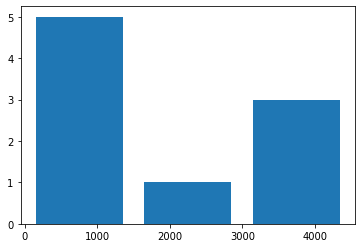

In [11]:
small = len(areas[areas < 1500])
medium = len(areas) - (len(areas[areas < 1500]) + len(areas[areas >= 3000]))
big = len(areas[areas >= 3000])
plt.hist(x=areas, bins=[0, 1500, 3000, 4500], rwidth=.8)